<a href="https://colab.research.google.com/github/Abonvicine/ESTUDOS---Gerais/blob/main/TG_Previs%C3%A3o_de_carga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
baseDIR = "/content/drive/MyDrive/TG/DADOS SUDESTE"

In [3]:
os.listdir(baseDIR)

['SECO_2021-01-27_CARGAHIST.csv',
 'SECO_2021-01-27_TEMPHIST.csv',
 'SECO_2021-01-27_FERIADOS.csv',
 'SECO_2021-01-27_SEPARADOR.csv',
 'SECO_2021-01-27_HORAVERAO.csv',
 'SECO_2021-01-27_PATAMARES.csv',
 'SECO_2021-01-27_HORIZONTE.csv',
 'SECO_2021-01-27_TEMPPREV.csv',
 'SECO_2021-01-27_COMBINA.csv']

In [4]:
historicoCarga = pd.read_csv(os.path.join(baseDIR,'SECO_2021-01-27_CARGAHIST.csv'),sep=";",decimal=",")
historicoTemperatura = pd.read_csv(os.path.join(baseDIR,'SECO_2021-01-27_TEMPHIST.csv'),sep=";",decimal=",")

In [5]:
historico = historicoCarga.merge(historicoTemperatura)
historico = historico.drop(["Min"], axis = 1 )
historico

,Ano,Mes,Dia,Hora,Carga,Temperatura
0,2014,1,1,1,31681.2,24.648
1,2014,1,1,2,31475.9,24.530
2,2014,1,1,3,30848.3,23.857
3,2014,1,1,4,29885.6,23.857
4,2014,1,1,5,29157.3,23.759
...,...,...,...,...,...,...
61986,2021,1,26,19,44932.8,27.639
61987,2021,1,26,20,47868.2,26.278
61988,2021,1,26,21,48407.8,25.949
61989,2021,1,26,22,48234.6,25.507


In [24]:
normalizador = MinMaxScaler( feature_range=(0,1))
# normalizador = StandardScaler()
historico[["Carga", "Temperatura"]] = normalizador.fit_transform(historico[["Carga", "Temperatura"]])
historico = historico.dropna()

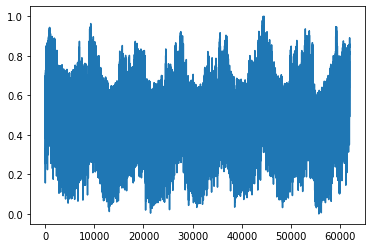

In [41]:
plt.plot(historico["Carga"])

In [26]:
base = historico.values

In [43]:
diasAnteriores = 30*24

In [45]:
previsores = []
valorReal = []

for i in range(diasAnteriores,len(base)):
    previsores.append(base[i - diasAnteriores:i, 4:6])
    valorReal.append(base[i, 4:6])

previsores, valorReal = np.array(previsores), np.array(valorReal)
previsores.shape

(61265, 720, 2)

In [48]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True,input_shape = (previsores.shape[1],2)))
model.add(Dropout(0.3))

# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.3))

# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.3))

model.add(LSTM(units = 50))
model.add(Dropout(0.3))

model.add(Dense(units = 2, activation= "sigmoid"))

model.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["mean_absolute_error"])

es = EarlyStopping(monitor = "loss", min_delta = 1e-10, patience = 10, verbose = 1)
rlr = ReduceLROnPlateau(monitor = "loss", factor = 0.2, patience = 5, verbose = 1)
mcp = ModelCheckpoint(filepath="pesos.h5", monitor = "loss", save_best_only = True, verbose=1)

In [ ]:
model.fit(previsores, valorReal, epochs = 100, batch_size = 32, callbacks=[es,rlr,mcp])

In [50]:
testeDIR = "/content/drive/MyDrive/TG/TESTE" 

In [52]:
historicoCargaTeste = pd.read_csv(os.path.join(testeDIR,'SECO_2021-01-31_CARGAHIST.csv'),sep=";",decimal=",")
historicoTemperaturaTeste = pd.read_csv(os.path.join(testeDIR,'SECO_2021-01-31_TEMPHIST.csv'),sep=";",decimal=",")

In [59]:
historicoTeste = historicoCargaTeste.merge(historicoTemperaturaTeste)
historicoTeste = historicoTeste.drop(["Min"], axis = 1 )
historicoTeste

,Ano,Mes,Dia,Hora,Carga,Temperatura
0,2014,1,1,1,31681.2,24.648
1,2014,1,1,2,31475.9,24.530
2,2014,1,1,3,30848.3,23.857
3,2014,1,1,4,29885.6,23.857
4,2014,1,1,5,29157.3,23.759
...,...,...,...,...,...,...
62082,2021,1,30,19,44577.2,29.184
62083,2021,1,30,20,48057.6,28.052
62084,2021,1,30,21,47910.1,26.647
62085,2021,1,30,22,46934.1,25.682


In [67]:
historicoTeste[["Carga", "Temperatura"]] = normalizador.fit_transform(historicoTeste[["Carga", "Temperatura"]])

In [68]:
historicoTeste

,Ano,Mes,Dia,Hora,Carga,Temperatura
0,2014,1,1,1,0.329023,0.623677
1,2014,1,1,2,0.322514,0.619916
2,2014,1,1,3,0.302616,0.598464
3,2014,1,1,4,0.272095,0.598464
4,2014,1,1,5,0.249004,0.595340
...,...,...,...,...,...,...
62082,2021,1,30,19,0.737879,0.768265
62083,2021,1,30,20,0.848223,0.732182
62084,2021,1,30,21,0.843546,0.687396
62085,2021,1,30,22,0.812603,0.656636


In [80]:
entradas = historicoTeste[len(historicoTeste) - diasAnteriores:].values
entradas.shape

(720, 6)

In [79]:
X_teste = []

for i in range(diasAnteriores,len(entradas)):
    X_teste.append(entradas[i-diasAnteriores:i, 4:6])
X_teste = np.array(X_teste)
X_teste.shape

(0,)